In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym
import gym_connect4

import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from mcts.mcts_strategy import MctsStrategy

In [2]:
# Create env
env = gym.make('Connect4Env-v0')

In [6]:
# This agent allow an human to play

class HumanAgent():

    def __init__(self):
        self.input = -1

    def step_exploit(self, obv):
        self.input = int(input('Your action:'))
        return self.input

In [7]:
class RandomAgent():

    def __init__(self):
        pass

    def step_exploit(self, obv):
        actions = [index for index, action in enumerate(obv['action_mask'][:-1]) if action == 1]
        return random.choice(actions)

In [8]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(input_shape[0], 128, kernel_size=4)

        self.lin1 = nn.Linear(1536, 64)
        self.lin2 = nn.Linear(64, 64)
        self.lin3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = torch.flatten(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

def memory_to_batch(memory):
    states = []
    actions = []
    rewards = []

    for (state, action, reward) in memory:
        states.append(state)
        actions.append(action)
        rewards.append(reward)

    return (torch.tensor(states), torch.tensor(actions), torch.tensor(rewards))

def calc_loss(memory, net):
    states_v, actions_v, rewards_v = memory_to_batch(memory)

    print(net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1))

In [13]:
class Agent:
    def __init__(self, nb_actions, epsilon, epsilon_decay_factor, min_epsilon, alpha, gamma):
        self.epsilon = epsilon
        self.epsilon_decay_factor = epsilon_decay_factor
        self.min_epsilon = min_epsilon
        self.alpha = alpha
        self.gamma = gamma

        self.nb_actions = nb_actions
        self.obv_shape = (1, 6, 7)

        self.action = -1

        self.memory = []

        self.net = DQN(self.obv_shape, self.nb_actions)
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=0.01)

        # Lists used to keep track of the training progression
        self.nb_game = 0
        self.learning_stats = {
            'epsilon': [],
            'random_wins': []
        }

    def __boardToTorch__(self, obv):
        return torch.unsqueeze(torch.tensor(obv, dtype=torch.float).reshape(self.obv_shape), 0)

    def __argmax__(self, action_probs):
        max_q_value = max(action_probs)
        actions = [index for index, q_value in enumerate(action_probs) if q_value == max_q_value]
        return random.choice(actions)

    def step(self, obv):  
        self.state_v = self.__boardToTorch__(obv['board'])

        if random.uniform(0, 1) < self.epsilon:
            actions = [index for index, action in enumerate(obv['action_mask'][:-1]) if action == 1]
            self.action = random.choice(actions)

        else:
            q_vals = self.net(self.state_v).data.numpy()

            q_vals = [q_vals[index] if action == 1 else float('-inf')
                      for index, action in enumerate(obv['action_mask'][:-1])]

            self.action = self.__argmax__(q_vals)

        return self.action

    def push_memory(self, reward):
        self.memory.append((self.state_v, self.action, reward))
    
    def flush_memory(self):
        self.memory = []

    def __push_learning_stats__(self, reward):
        self.nb_game += 1        
        self.learning_stats['epsilon'].append(self.epsilon)

    def update_learning_stats(self):
        # Updates tracking values
        self.__push_learning_stats__(self.memory[-1][2])

    def learn(self):
        last_reward = 0

        for i in range(len(self.memory), 0, -1):
            (inputs, action, reward) = self.memory[i - 1]

            # reward:
            reward = reward + self.gamma * last_reward
            
            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward
            outputs = self.net(inputs)
            
            # q_reward:
            q_reward = outputs[action] + self.alpha * (reward - outputs[action])
            
            # backward
            loss = self.criterion(q_reward, outputs[action])
            loss.backward()
            
            # optimize
            self.optimizer.step()
            last_reward = reward
            
        self.epsilon = max(min_epsilon, self.epsilon - self.epsilon_decay_factor)

    def step_exploit(self, obv):
        # Steps through a turn in a real game (no random choices)
        self.state_v = self.__boardToTorch__(obv['board'])
        q_vals = self.net(self.state_v).data.numpy()

        q_vals = [q_vals[index] if action == 1 else float('-inf')
                  for index, action in enumerate(obv['action_mask'][:-1])]

        q_vals = obv['action_mask'][:-1].astype(int) - 1

        self.action = self.__argmax__(q_vals)
        return self.action

    def test_random(self, nb_games):
        # Plays 'nb_games' games against a random agent and plots its result.
        agents = [ self, RandomAgent() ]
        actions = {0: 0, 1: 0}
        wins = 0

        for game_number in range(nb_games):
            obv = env.reset()
            done = False

            agent_nb = game_number % 2
            turn = 0

            while not done:
                actions[turn] = agents[agent_nb].step_exploit(obv[turn])
                obv, reward, done, info = env.step(actions)

                turn = (turn + 1) % 2
                agent_nb = (agent_nb + 1) % 2

            if reward[game_number % 2] == 1:
                wins += 1
        
        self.learning_stats['random_wins'].append(wins)
    
    def display_epsilon(self):
        plt.plot(self.learning_stats['epsilon'])
        plt.xlabel('Epochs')
        plt.ylabel('Epsilon')
        plt.grid(True)
        plt.show()

    def display_random_wins(self):
        plt.plot(self.learning_stats['random_wins'])
        plt.xlabel('Epochs')
        plt.ylabel('Wins against random agent over 100 games')
        plt.grid(True)
        plt.show()

In [25]:
nb_game_action = 7

alpha = 0.01
gamma = 0.6

epsilon = 0.99999
min_epsilon = 0.1
epsilon_decay_factor = 0.00001

nb_epochs = 10000
nb_epochs_test = 100
nb_games_test = 100

In [26]:
agents = [
    Agent(nb_game_action, epsilon, epsilon_decay_factor, min_epsilon, alpha, gamma),
    Agent(nb_game_action, epsilon, epsilon_decay_factor, min_epsilon, alpha, gamma)
]

In [27]:
actions = {0: 0, 1: 0}

for epoch in tqdm.tqdm(range(nb_epochs)):
    # Reset the env and get the first board status
    obv = env.reset()
    done = False

    # Switch the playing agent
    agent_nb = epoch % 2 
    turn = 0

    while not done:
        actions[turn] = agents[agent_nb].step(obv[turn])
        obv, reward, done, info = env.step(actions)

        agents[agent_nb].push_memory(reward[turn])

        turn = (turn + 1) % 2
        agent_nb = (agent_nb + 1) % 2

    for a in agents:
        a.update_learning_stats()
        a.learn()
        a.flush_memory()

    if epoch % nb_epochs_test == 0:
        agents[0].test_random(nb_games_test)

agent = agents[0]

100%|██████████| 10000/10000 [10:53<00:00, 15.31it/s]


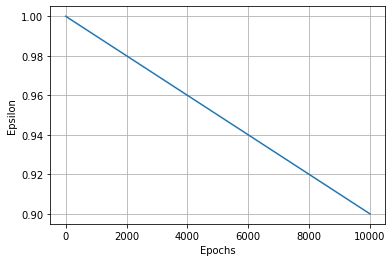

In [28]:
agent.display_epsilon()

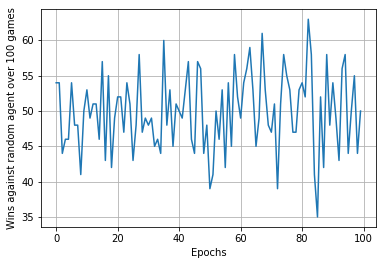

In [29]:
agent.display_random_wins()

In [54]:
# PLay against your agent:
players_agent = [agents[0], HumanAgent()]

# The agent will act with its own knowledge, there no exploration:
obv = env.reset()
turn = 0

done = False
actions = {0: 0, 1: 0}

env.render()

while not done:
    actions[turn] = players_agent[turn].step_exploit(obv[turn])
    obv, reward, done, info = env.step(actions)

    turn = (turn + 1) % 2

    env.render()
    print('')

  1 2 3 4 5 6 7
 ---------------
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
 ---------------
  1 2 3 4 5 6 7
  1 2 3 4 5 6 7
 ---------------
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]]
 ---------------
  1 2 3 4 5 6 7

Your action:0
  1 2 3 4 5 6 7
 ---------------
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [2 0 0 0 0 0 1]]
 ---------------
  1 2 3 4 5 6 7

  1 2 3 4 5 6 7
 ---------------
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [2 0 0 0 0 0 1]]
 ---------------
  1 2 3 4 5 6 7

Your action:0
  1 2 3 4 5 6 7
 ---------------
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [2 0 0 0 0 0 1]
 [2 0 0 0 0 0 1]]
 ---------------
  1 2 3 4 5 6 7

  1 2 3 4 5 6 7
 ---------------
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [2 0 0 0 0 0 1]
 [2 0